# GOTCHA
**General purpose Online Tool for Captcha HAndling**

GOTCHA is a python module intended to provide a way for handling [CAPTCHAs](https://en.wikipedia.org/wiki/CAPTCHA) in automated testing. GOTCHA accepts images represented as numpy arrays and returns a character string with its guess. GOTCHA is not meant to be used for bypassing any actual security measures - This is why it will only work with extremely simple captchas such as _Simple PHP CAPTCHA_ or the _Really simple CAPTCHA plugin_ for WordPress. 

This notebook provides an in-depth explanation of how GOTCHA works and how well it performs.

## Dependencies

GOTCHA requires:
* Python 3
* The Python modules listed in the import-section
* A running installation of tesseract

Install Tesseract on Debian/Ubuntu:
```bash
$ sudo apt-get install tesseract-ocr
```

Install Tesseract on macOS:
```bash
$ brew install tesseract
```


## Preparations

In [1]:
# Workaround: Prevents Jupyter Notebook from crashing when trying to display images
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Import relevant libraries
import os
import cv2
import glob
import pytesseract
import numpy as np
from PIL import Image
from scipy import ndimage

In [3]:
# Constructing path to evaluation directory
VAL_PATH = os.path.join(os.getcwd(),"dataset")

In [4]:
# Generate a list of files in data directory
captcha_filelist = glob.glob(os.path.join(VAL_PATH, "*"))

In [5]:
def solve_captcha(image, deskew=True, verbose=False):
    if verbose:
        print("Original Image")
        plt.imshow(image)
        plt.show()
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    if verbose:
        print("Applying Mean Shift Filtering")
        plt.imshow(shifted)
        plt.show()
    # Skewness corection:
    # https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/

    # Convert to greyscale and perform bitflip to inverse image
    image_greyscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_greyscale = cv2.bitwise_not(image_greyscale)

    # Thresholding the image, setting all foreground pixels to 0 and background pixels to 255.
    # Results in a black and white image
    image_bw = cv2.threshold(image_greyscale, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    if verbose:
        print("Converting to binary image for further processing")
        plt.imshow(image_bw)
        plt.show()
    
    # Deskew if necessary
    if deskew:
        # Get non-zero pixels
        coords = np.column_stack(np.where(image_bw > 0))
        # Get rotation angle
        angle = cv2.minAreaRect(coords)[-1]
        # Adjust angles to avoid flipping text upside down
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        # Rotation
        (h, w) = image_bw.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image_deskewed = cv2.warpAffine(image_bw, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        if verbose:
            print("Correcting for skewness")
            plt.imshow(image_deskewed)
            plt.show()
    else:
        image_deskewed = image_bw
    
    # Median Blur
    image_median_blur = cv2.medianBlur(image_deskewed,3)
    if verbose:
        print("Applying median blur")
        plt.imshow(image_median_blur)
        plt.show()
    
    # Converting image back to color for kernel methods
    image_median_blur = cv2.cvtColor(image_median_blur,cv2.COLOR_GRAY2BGR)
    # erode and dilate
    kernel = np.ones((2,2),np.uint8)
    image_eroded_dilated= cv2.erode(image_median_blur,kernel,iterations = 1)
    image_eroded_dilated = cv2.dilate(image_eroded_dilated,kernel,iterations = 1)
    # Flip colors
    image_eroded_dilated = (255-image_eroded_dilated)    
    if verbose:
        print("Eroding and delating")
        plt.imshow(image_eroded_dilated)
        plt.show()
    
    # Converting ndarray to image for OCR processing
    ocr_image = Image.fromarray(image_eroded_dilated)
    # Actual ocr
    txt = pytesseract.image_to_string(ocr_image, 
        config="-c tessedit_char_whitelist=01234567890ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz --psm 11")
    return txt

## Example

Original Image


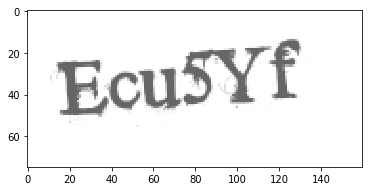

Applying Mean Shift Filtering


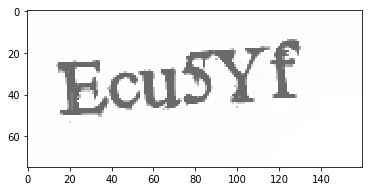

Converting to binary image for further processing


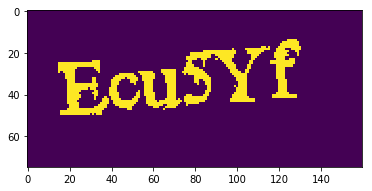

Correcting for skewness


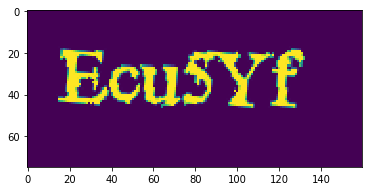

Applying median blur


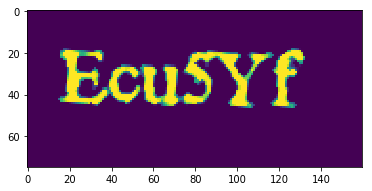

Eroding and delating


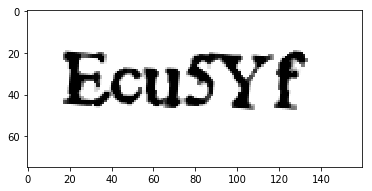

'EcuS5Yf'

In [6]:
example_captcha = cv2.imread(captcha_filelist[90])
solve_captcha(example_captcha, verbose=True)

# EVALUATION

In [7]:
import pandas as pd
import tqdm
import pycm
import itertools

In [8]:
true_text, guess_text, true_nchar, guess_nchar, correct = [],[],[],[],[]
true_vector, guess_vector = "",""

In [9]:
for f in tqdm.tqdm(captcha_filelist[0:1000]):
    basename = os.path.basename(f)
    solution = os.path.splitext(basename)[0]
    solution_len = len(solution)
    img = cv2.imread(f)
    guess = solve_captcha(img)
    guess_len = len(guess)
    guess_correct = solution==guess
    true_text.append(solution)
    guess_text.append(guess)
    true_nchar.append(solution_len)
    guess_nchar.append(guess_len)
    correct.append(guess_correct)
    if guess_len==solution_len:
        true_vector += solution
        guess_vector += guess

100%|██████████| 1000/1000 [03:38<00:00,  4.28it/s]


In [10]:
df = pd.DataFrame(list(zip(true_text, guess_text, true_nchar, guess_nchar, correct)), 
               columns =["Solution","Guess","Length Solution", "Length Guess", "Guess correct"]) 

In [11]:
share_correct = sum(correct)/len(correct)*100
print("Correct guesses: " + str(share_correct) +"%")

Correct guesses: 65.8%


In [12]:
df.head()

,Solution,Guess,Length Solution,Length Guess,Guess correct
0,cAGzG,cAGzG,5,5,True
1,ZJS7jm,Z3S7jm,6,6,False
2,mnygS,mnygS,5,5,True
3,2RrvgE,2RrvgE,6,6,True
4,7eF3DG,TeF3DG,6,6,False


In [13]:
true_vector = list(true_vector)
guess_vector = list(guess_vector)

In [14]:
cm = pycm.ConfusionMatrix(actual_vector=true_vector, predict_vector=guess_vector)

In [15]:
# Visualisation Funciton taken froM:
# https://www.pycm.ir/doc/Example2.html

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function modified to plots the ConfusionMatrix object.
    Normalization can be applied by setting `normalize=True`.
    
    Code Reference : 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """

    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    if normalize:
        plt_cm = plt_cm.astype('float') / plt_cm.sum(axis=1)[:, np.newaxis]     
    plt.imshow(plt_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(cm.classes))
    plt.xticks(tick_marks, cm.classes, rotation=45)
    plt.yticks(tick_marks, cm.classes)

    fmt = '.2f' if normalize else 'd'
    thresh = plt_cm.max() / 2.
    for i, j in itertools.product(range(plt_cm.shape[0]), range(plt_cm.shape[1])):
        plt.text(j, i, format(plt_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if plt_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predict')

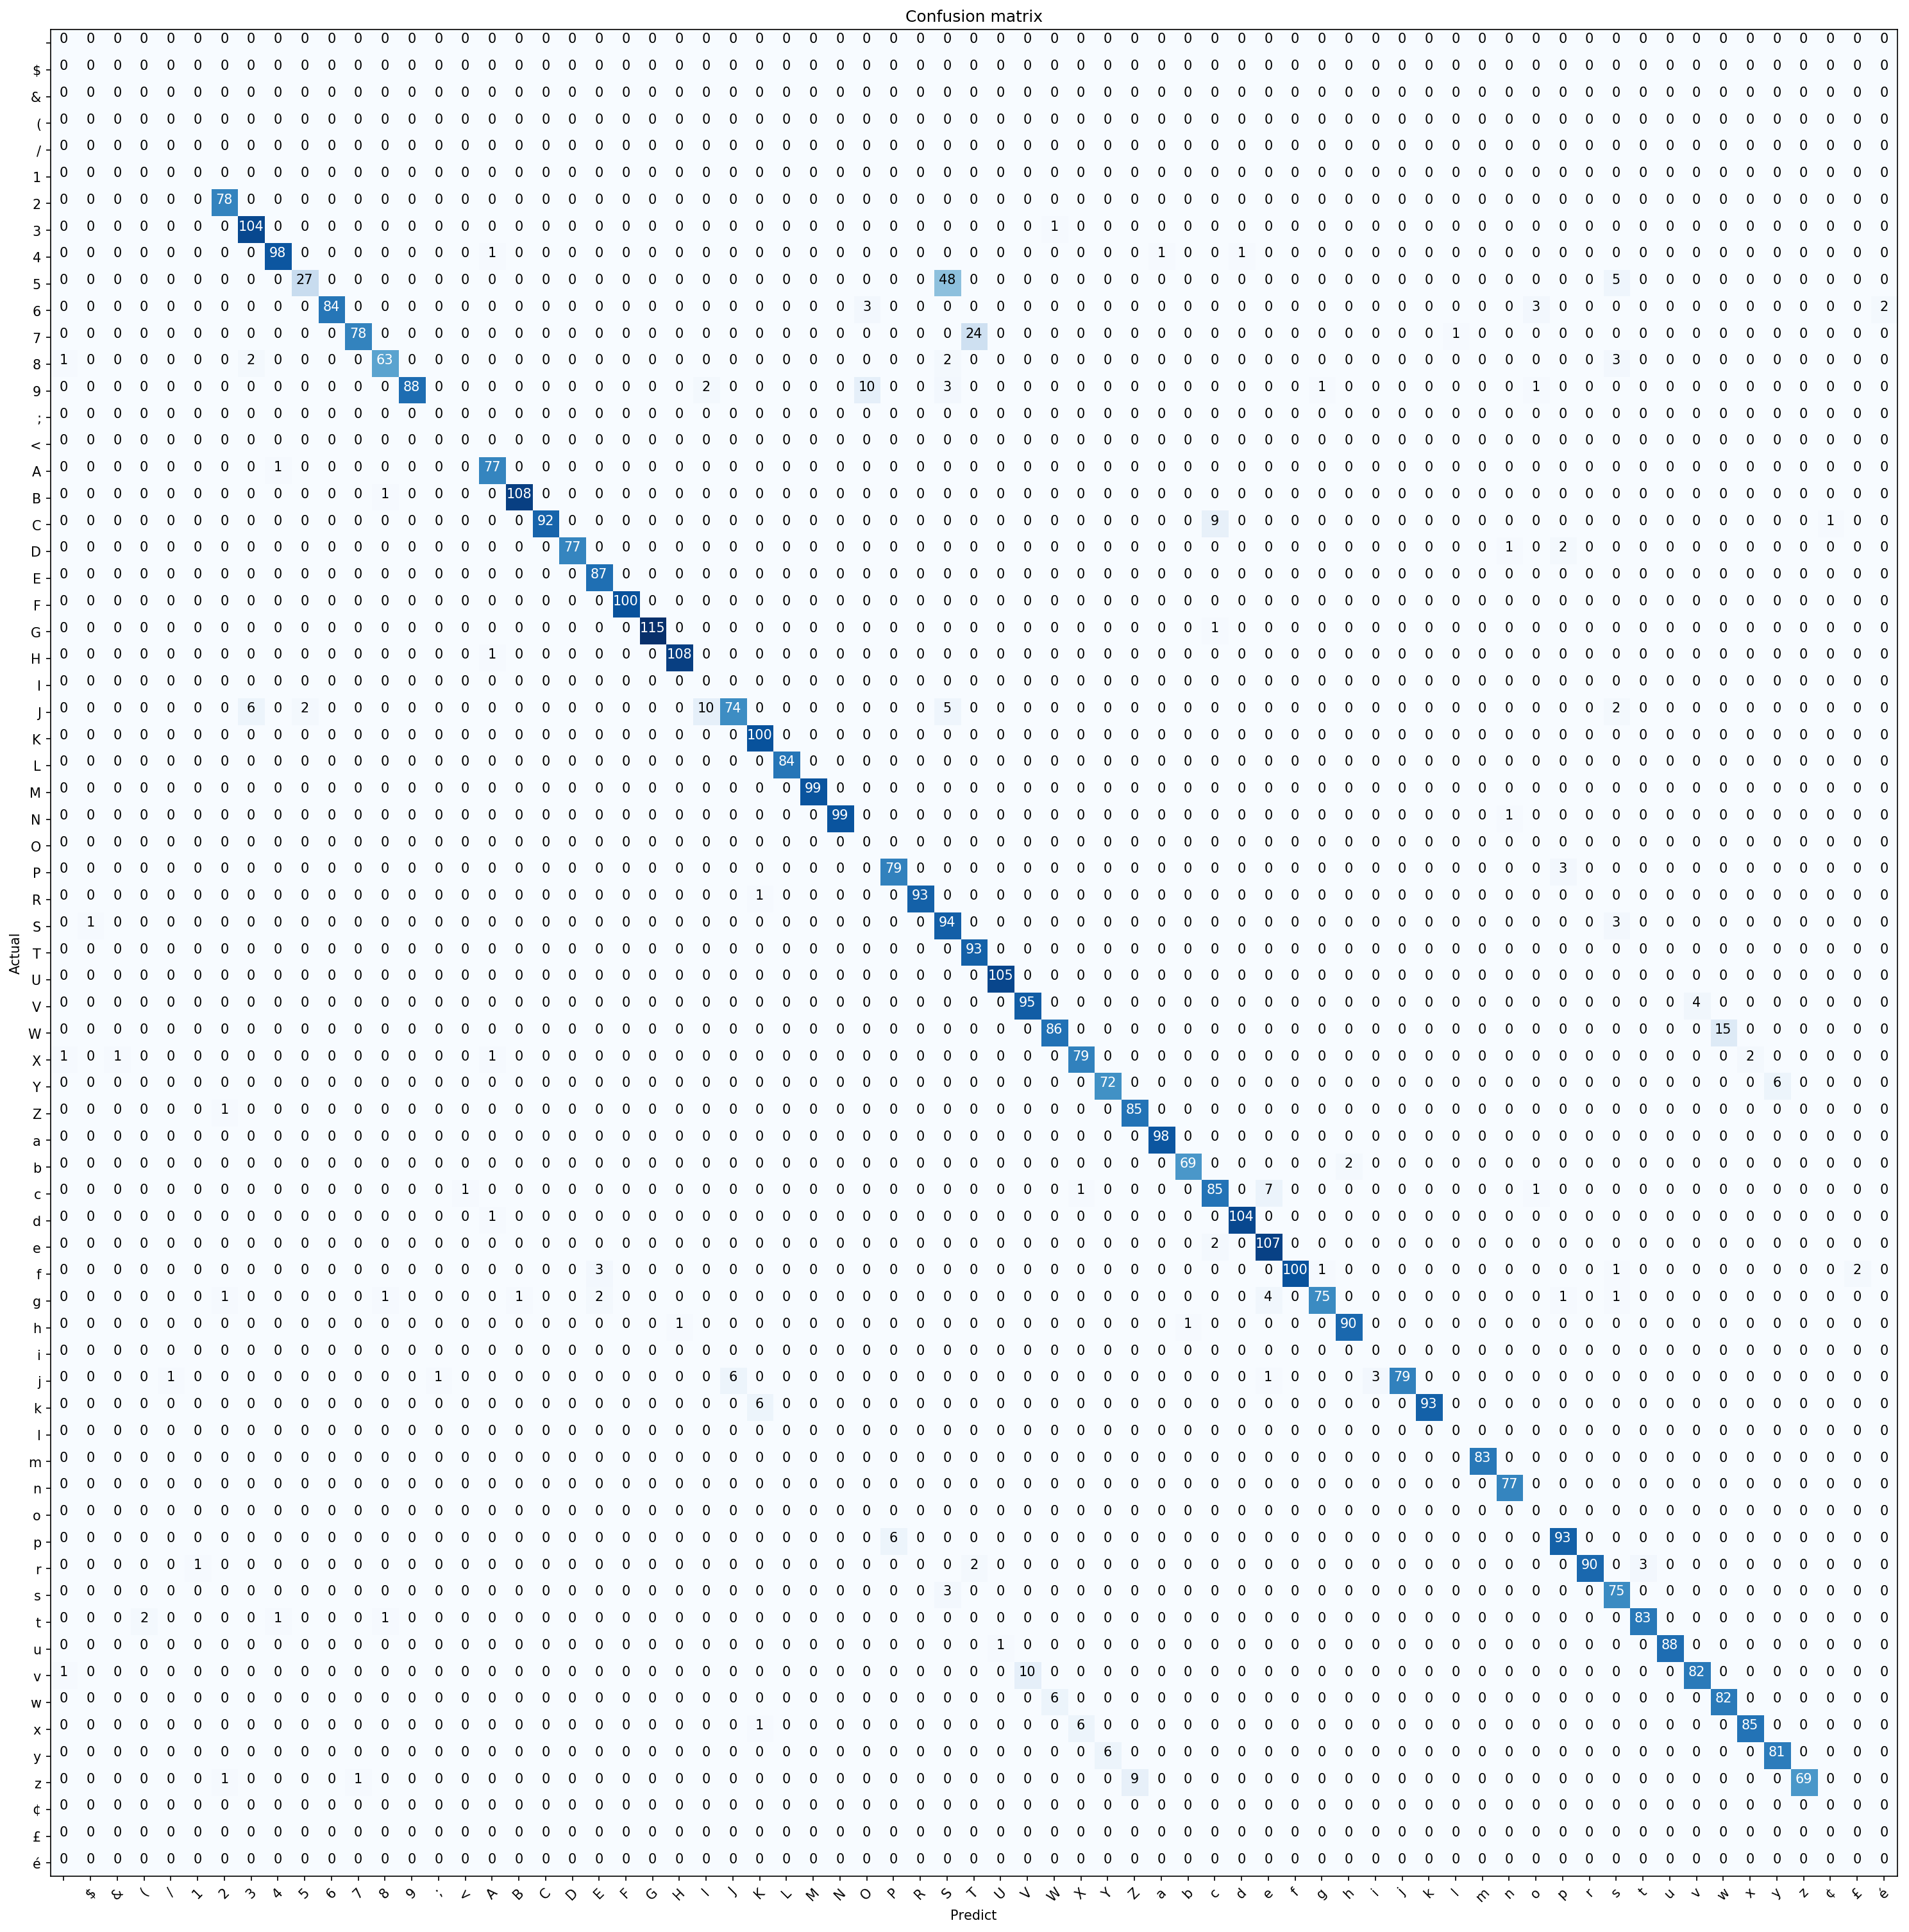

In [16]:
plt.figure(num=None, figsize=(20,20), dpi=150)
plot_confusion_matrix(cm, normalize=False)
plt.show()